In [1]:
import matplotlib as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import tensorflow.keras

In [2]:
from scipy.interpolate import interp1d

def get_func_length(x_train, func):
    if func == min:
        func_length = np.inf
    else:
        func_length = 0

    n = x_train.shape[0]
    for i in range(n):
        func_length = func(func_length, x_train[i].shape[1])

    return func_length


def transform_to_same_length(x, n_var, max_length):
    n = x.shape[0]

    # the new set in ucr form np array
    ucr_x = np.zeros((n, max_length, n_var), dtype=np.float64)

    # loop through each time series
    for i in range(n):
        mts = x[i]
        curr_length = mts.shape[1]
        idx = np.array(range(curr_length))
        idx_new = np.linspace(0, idx.max(), max_length)
        for j in range(n_var):
            ts = mts[j]
            # linear interpolation
            f = interp1d(idx, ts, kind='cubic')
            new_ts = f(idx_new)
            ucr_x[i, :, j] = new_ts

    return ucr_x

In [3]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [4]:
from scipy.io import loadmat
# REPLACE WITH YOUR DIRECTORY
out_dir = 'C:\\Users\\'
a = loadmat('xy1200.mat')
a = a['ra']
a = a[0, 0]

dt = a.dtype.names
dt = list(dt)

for i in range(len(dt)):
    if dt[i] == 'samples':
        x_train = a[i].reshape(max(a[i].shape))
    elif dt[i] == 'labels':
        y_train = a[i]

n_var = x_train[0].shape[0]

max_length = get_func_length(x_train, func=max)
min_length = get_func_length(x_train, func=min)

print('effect_ra ', 'max', max_length, ' min', min_length)

x_train = transform_to_same_length(x_train, n_var, max_length)

np.save(out_dir + 'x.npy', x_train)
np.save(out_dir + 'y.npy', y_train)

print('Done')

effect_ra  max 500  min 500
Done


In [5]:
data = np.load("x.npy")
target = np.load("y.npy")

In [6]:
print(data.shape)
print(target.shape)

(1200, 500, 24)
(1200, 4)


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(data, target, test_size=0.2)
print('dataset: X_train:', x_train.shape, 'Y_train:', y_train.shape, 'X_test:', x_test.shape, 'Y_test', y_test.shape)

dataset: X_train: (960, 500, 24) Y_train: (960, 4) X_test: (240, 500, 24) Y_test (240, 4)


In [8]:
from keras.models import Model
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Flatten
from keras.layers import Input, Dense, LSTM, concatenate, Activation, Add, AveragePooling1D
from keras.layers import MaxPool1D

In [9]:
input_shape = x_train.shape[1:]
num_class = 4

In [10]:
from keras.layers import Concatenate
#inception model
def _inception_module(input_tensor, stride=1, activation='linear', use_bottleneck=True, bottleneck_size=32,
                      kernel_size=40, nb_filters=32):
    if use_bottleneck and int(input_tensor.shape[-1]) > bottleneck_size:
        input_inception = Conv1D(filters=bottleneck_size, kernel_size=1,
                                 padding='same', activation=activation, use_bias=False)(input_tensor)
    else:
        input_inception = input_tensor

    kernel_size_s = [kernel_size // (2 ** i) for i in range(3)]
    conv_list = []
    for i in range(len(kernel_size_s)):
        conv_list.append(Conv1D(filters=nb_filters, kernel_size=kernel_size_s[i], strides=stride, padding='same',
                                activation=activation, use_bias=False)(input_inception))
    max_pool_1 = MaxPool1D(pool_size=3, strides=stride, padding='same')(input_tensor)
    conv_6 = Conv1D(filters=nb_filters, kernel_size=1, padding='same',
                    activation=activation, use_bias=False)(max_pool_1)
    conv_list.append(conv_6)
    x = Concatenate(axis=2)(conv_list)
    x = BatchNormalization()(x)
    x = Activation(activation='swish')(x)
    return x


def _shortcut_layer(input_tensor, out_tensor):
    shortcut_y = Conv1D(filters=int(out_tensor.shape[-1]), kernel_size=1, padding='same', use_bias=False)(input_tensor)
    shortcut_y = BatchNormalization()(shortcut_y)
    x = Add()([shortcut_y, out_tensor])
    x = Activation('swish')(x)
    return x


def generate_inception(INPUT_SHAPE, NB_CLASS, use_residual=True, depth=6):
    input_layer = Input(INPUT_SHAPE)
    x = input_layer
    input_res = input_layer
    for d in range(depth):
        x = _inception_module(x)
        if use_residual and d % 3 == 2:
            x = _shortcut_layer(input_res, x)
            input_res = x
    gap_layer = GlobalAveragePooling1D()(x)
    output_layer = Dense(NB_CLASS, activation='sigmoid')(gap_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

inception_model = generate_inception(input_shape, num_class)

In [11]:
#ResNet Model
def generate_resnet(INPUT_SHAPE, NB_CLASS):
    n_feature_maps = 32
    input_layer = Input(INPUT_SHAPE)
    # BLOCK 1
    conv_x = Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('swish')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('swish')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # expand channels for the sum
    shortcut_y = Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = BatchNormalization()(shortcut_y)
    output_block_1 = Add()([shortcut_y, conv_z])
    output_block_1 = Activation('swish')(output_block_1)
    # BLOCK 2
    conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('swish')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('swish')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # expand channels for the sum
    shortcut_y = Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = BatchNormalization()(shortcut_y)
    output_block_2 = Add()([shortcut_y, conv_z])
    output_block_2 = Activation('swish')(output_block_2)
    # BLOCK 3
    conv_x = Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('swish')(conv_x)
    conv_y = Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = BatchNormalization()(conv_y)
    conv_y = Activation('swish')(conv_y)
    conv_z = Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = BatchNormalization()(conv_z)
    # no need to expand channels because they are equal
    shortcut_y = BatchNormalization()(output_block_2)
    output_block_3 = Add()([shortcut_y, conv_z])
    output_block_3 = Activation('swish')(output_block_3)
    # FINAL
    gap_layer = GlobalAveragePooling1D()(output_block_3)
    output_layer = Dense(NB_CLASS, activation='sigmoid')(gap_layer)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model


resnet_model = generate_resnet(input_shape, num_class)

In [12]:
#best threshold calculator for changing nonbinary output labels to binary

from sklearn import metrics
import argparse


from sklearn.metrics import matthews_corrcoef


def threshold_calibration_matthews_corrcoef(LABEL, SCORE):
    Pred = SCORE
    Truth = LABEL
    threshold = np.arange(0.1, 0.9, 0.1)
    acc = []
    accuracies = []
    best_threshold = np.zeros(Pred.shape[1])
    for i in range(Pred.shape[1]):
        y_prob = np.array(Pred[:, i])
        for j in threshold:
            y_pred = [1 if prob >= j else 0 for prob in y_prob]
            acc.append(matthews_corrcoef(Truth[:, i], y_pred))
        acc = np.array(acc)
        index = np.where(acc == acc.max())
        accuracies.append(acc.max())
        best_threshold[i] = threshold[index[0][0]]
        acc = []

    return best_threshold


In [13]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
#START Inception
batch_size = 15
num_epoch = 100
learning_rate = .001
mini_batch_size = int(min(x_train.shape[0]/10, batch_size))
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
stop_early = EarlyStopping(monitor='val_accuracy', patience=40, mode='max', restore_best_weights=True)
optm = Adam(lr=learning_rate)

In [ ]:
inception_model.summary()

In [ ]:
resnet_model.summary()

In [14]:
seq = inception_model
seq.compile(optimizer=optm, loss='binary_crossentropy', metrics=['accuracy'])
history = seq.fit(x_train, y_train,
                  batch_size=mini_batch_size,
                  epochs=num_epoch,
                  shuffle=True,
                  verbose=1,
                  validation_split=0.0,
                  validation_data=(x_train, y_train),
                  callbacks=[reduce_lr_loss])

Epoch 1/100
64/64 [==============================] - 22s 336ms/step - loss: 0.4810 - accuracy: 0.7448 - val_loss: 276.1552 - val_accuracy: 0.7833
Epoch 2/100
15/64 [======>.......................] - ETA: 13s - loss: 0.3692 - accuracy: 0.8889

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix, confusion_matrix
y_pred = inception_model.predict(x_test)
best_threshold = threshold_calibration_matthews_corrcoef(LABEL=y_train, SCORE=inception_model.predict(x_train))
y_pred_binary = np.array(
    [[1 if y_pred[i, j] >= best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

for i in range (0,20):
    print(y_pred_binary[i])  
    print(y_test[i]) 
    plt.pyplot.plot(x_test[i,:,0:11])
    plt.pyplot.show() 
    print()


print('F1_score(Micro):', f1_score(y_test, y_pred_binary, average='micro'))
print('F1_score(Macro):', f1_score(y_test, y_pred_binary, average='macro'))
print('presicion Score(Micro):', precision_score(y_test, y_pred_binary, average='micro'))
print('presicion Score(Macro):', precision_score(y_test, y_pred_binary, average='macro'))
print('recall Score(Micro):', recall_score(y_test, y_pred_binary, average='micro'))
print('recall Score(Macro):', recall_score(y_test, y_pred_binary, average='macro'))
print('Acc_score:', accuracy_score(y_test, y_pred_binary))
print(multilabel_confusion_matrix(y_test, y_pred_binary))
print('Acc_score Normal:', accuracy_score(y_test[:,0], y_pred_binary[:,0]))
print('Acc_score Load Change:', accuracy_score(y_test[:,1], y_pred_binary[:,1]))
print('Acc_score Voltage Attack:', accuracy_score(y_test[:,2], y_pred_binary[:,2]))
print('Acc_score Power Attack:', accuracy_score(y_test[:,3], y_pred_binary[:,3]))

inception_model.summary()

In [21]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2

ipykernel_launcher:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


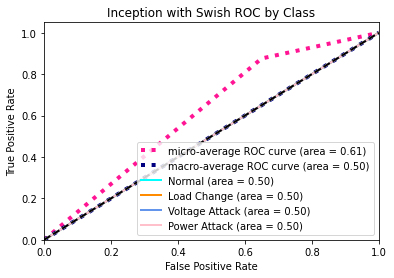

In [25]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
n_classes = 4
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'pink'])
for i, color in zip(range(n_classes), colors):
      if i == 0:
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Normal (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
      if i == 1:
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Load Change (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
      if i == 2:
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Voltage Attack (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
      if i == 3:
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Power Attack (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Inception with Swish ROC by Class')
plt.legend(loc="lower right")
plt.show()

In [26]:
#START ResNet
batch_size = 15
num_epoch = 100
learning_rate = .001
mini_batch_size = int(min(x_train.shape[0]/10, batch_size))
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, epsilon=1e-4, mode='min')
stop_early = EarlyStopping(monitor='val_accuracy', patience=35, mode='max', restore_best_weights=True)
optm = Adam(lr=learning_rate)

In [27]:
seq = resnet_model
seq.compile(optimizer=optm, loss='binary_crossentropy', metrics=['accuracy'])
history = seq.fit(x_train, y_train,
                  batch_size=mini_batch_size,
                  epochs=num_epoch,
                  shuffle=True,
                  verbose=1,
                  validation_split=0.0,
                  validation_data=(x_train, y_train),
                  callbacks=[reduce_lr_loss])

Epoch 1/100
64/64 [==============================] - 8s 119ms/step - loss: 0.4618 - accuracy: 0.7500 - val_loss: 26.7788 - val_accuracy: 0.7833
Epoch 2/100
 8/64 [==>...........................] - ETA: 4s - loss: 0.3651 - accuracy: 0.8000

KeyboardInterrupt: 

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, multilabel_confusion_matrix
y_pred = resnet_model.predict(x_test)
best_threshold = threshold_calibration_matthews_corrcoef(LABEL=y_train, SCORE=resnet_model.predict(x_train))
y_pred_binary = np.array(
    [[1 if y_pred[i, j] >= best_threshold[j] else 0 for j in range(y_test.shape[1])] for i in range(len(y_test))])

# for i in range(20):
#     print(y_pred_binary[i])  
#     print(y_test[i]) 
#     plt.pyplot.plot(x_test[i,:,0:11])
#     plt.pyplot.show() 
#     print()

print('F1_score(Micro):', f1_score(y_test, y_pred_binary, average='micro'))
print('F1_score(Macro):', f1_score(y_test, y_pred_binary, average='macro'))
print('presicion Score(Micro):', precision_score(y_test, y_pred_binary, average='micro'))
print('presicion Score(Macro):', precision_score(y_test, y_pred_binary, average='macro'))
print('recall Score(Micro):', recall_score(y_test, y_pred_binary, average='micro'))
print('recall Score(Macro):', recall_score(y_test, y_pred_binary, average='macro'))
print('Acc_score:', accuracy_score(y_test, y_pred_binary))
print(multilabel_confusion_matrix(y_test, y_pred_binary))
print('Acc_score Normal:', accuracy_score(y_test[:,0], y_pred_binary[:,0]))
print('Acc_score Load Change:', accuracy_score(y_test[:,1], y_pred_binary[:,1]))
print('Acc_score Voltage Attack:', accuracy_score(y_test[:,2], y_pred_binary[:,2]))
print('Acc_score Power Attack:', accuracy_score(y_test[:,3], y_pred_binary[:,3]))


resnet_model.summary()

F1_score(Micro): 0.6509598603839442
F1_score(Macro): 0.49808631069972686
presicion Score(Micro): 0.5180555555555556
presicion Score(Macro): 0.3885416666666667
recall Score(Micro): 0.8755868544600939
recall Score(Macro): 0.75
Acc_score: 0.19583333333333333
[[[187   0]
  [ 53   0]]

 [[  0  53]
  [  0 187]]

 [[  0 152]
  [  0  88]]

 [[  0 142]
  [  0  98]]]
Acc_score Normal: 0.7791666666666667
Acc_score Load Change: 0.7791666666666667
Acc_score Voltage Attack: 0.36666666666666664
Acc_score Power Attack: 0.4083333333333333
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500, 24)]    0                                            
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 500, 32)      6

In [29]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
lw = 2

ipykernel_launcher:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


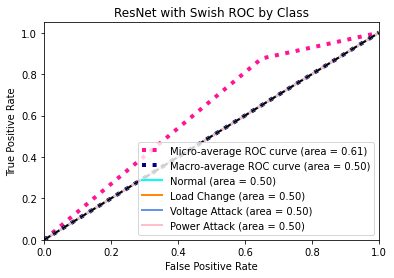

In [30]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
n_classes = 4
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'pink'])
for i, color in zip(range(n_classes), colors):
      if i == 0:
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Normal (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
      if i == 1:
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Load Change (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
      if i == 2:
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Voltage Attack (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
      if i == 3:
            plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Power Attack (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet with Swish ROC by Class')
plt.legend(loc="lower right")
plt.show()